In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm # progrss bars
from pmdarima import auto_arima
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import *
from sktime.utils.plotting import plot_correlations
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arima import ARIMA

from sktime.forecasting.base import ForecastingHorizon

from sktime.utils.plotting import plot_series

from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import seaborn as sns

from statsmodels.tsa.stattools import adfuller

import time 

from darts import TimeSeries
from darts.utils.statistics import check_seasonality

# https://www.kaggle.com/code/somertonman/time-series-classification-using-deep-learning

%matplotlib inline

Hourly data can have three seasonal periods: a daily pattern, a weekly pattern, and an annual pattern.

### Read in data

In [3]:
def read_csv_files_from_folder(folder_path):
    """
    Reads all CSV files from a specified folder and returns a concatenated DataFrame.
    
    Parameters:
    folder_path (str): The path to the folder containing CSV files.
    
    Returns:
    pd.DataFrame: A DataFrame containing the data from all CSV files.
    """
    # List to store individual DataFrames
    dataframes = []

    # Loop over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):  
            file_path = os.path.join(folder_path, filename)
            try:
                # Read the CSV into a DataFrame and append it to the list
                df = pd.read_csv(file_path)
                dataframes.append(df)
                print(f"Successfully read {filename} with shape {df.shape}")
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    
    # Concatenate all DataFrames into a single DataFrame
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(f"Combined DataFrame shape: {combined_df.shape}")
        return combined_df
    else:
        print("No CSV files were found in the folder.")
        return pd.DataFrame()


In [4]:
pwd = os.getcwd()
print(pwd)
folder_path = '../Data/electric/'
df = read_csv_files_from_folder(folder_path)

c:\Projects\TeSoPs\Syntax
Successfully read electriciteitsmix-2021-uur-data.csv with shape (8760, 13)
Successfully read electriciteitsmix-2022-uur-data.csv with shape (8760, 13)
Successfully read electriciteitsmix-2023-uur-data.csv with shape (8760, 13)
Successfully read electriciteitsmix-2024-uur-data.csv with shape (8112, 13)
Combined DataFrame shape: (34392, 13)


### Data Exploration 

In [5]:
#df = df.dropna()
df.head()

,validfrom (UTC),validto (UTC),point,type,granularity,timezone,activity,classification,capacity (kW),volume (kWh),percentage,emission (kg CO2),emissionfactor (kg CO2/kWh)
0,2020-12-31 23:00:00,2021-01-01 00:00:00,Nederland,ElectricityMix,Hour,UTC,Providing,Current,10899485,10899485,0.605003,3939727,0.361425
1,2021-01-01 00:00:00,2021-01-01 01:00:00,Nederland,ElectricityMix,Hour,UTC,Providing,Current,10180546,10180546,0.565084,3646349,0.358140
2,2021-01-01 01:00:00,2021-01-01 02:00:00,Nederland,ElectricityMix,Hour,UTC,Providing,Current,9166898,9166898,0.508808,3201484,0.349210
3,2021-01-01 02:00:00,2021-01-01 03:00:00,Nederland,ElectricityMix,Hour,UTC,Providing,Current,8063011,8063011,0.447527,2739129,0.339635
4,2021-01-01 03:00:00,2021-01-01 04:00:00,Nederland,ElectricityMix,Hour,UTC,Providing,Current,7712362,7712362,0.428055,2552202,0.330915


In [6]:
energy_df = df \
    .rename(columns = {'validto (UTC)' : 'date_time' ,
                      'emissionfactor (kg CO2/kWh)' : 'emissionfactor'}) \
    .drop(columns = ['validfrom (UTC)','point', 'granularity', 'percentage','type', 'timezone', 'emission (kg CO2)', 'activity', 'classification', 'capacity (kW)','volume (kWh)']) \
    .dropna() 

energy_df['date_time'] = pd.to_datetime(energy_df['date_time'])
    
    
print(energy_df.head())

            date_time  emissionfactor
0 2021-01-01 00:00:00        0.361425
1 2021-01-01 01:00:00        0.358140
2 2021-01-01 02:00:00        0.349210
3 2021-01-01 03:00:00        0.339635
4 2021-01-01 04:00:00        0.330915


In [7]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34392 entries, 0 to 34391
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       34392 non-null  datetime64[ns]
 1   emissionfactor  34392 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 537.5 KB


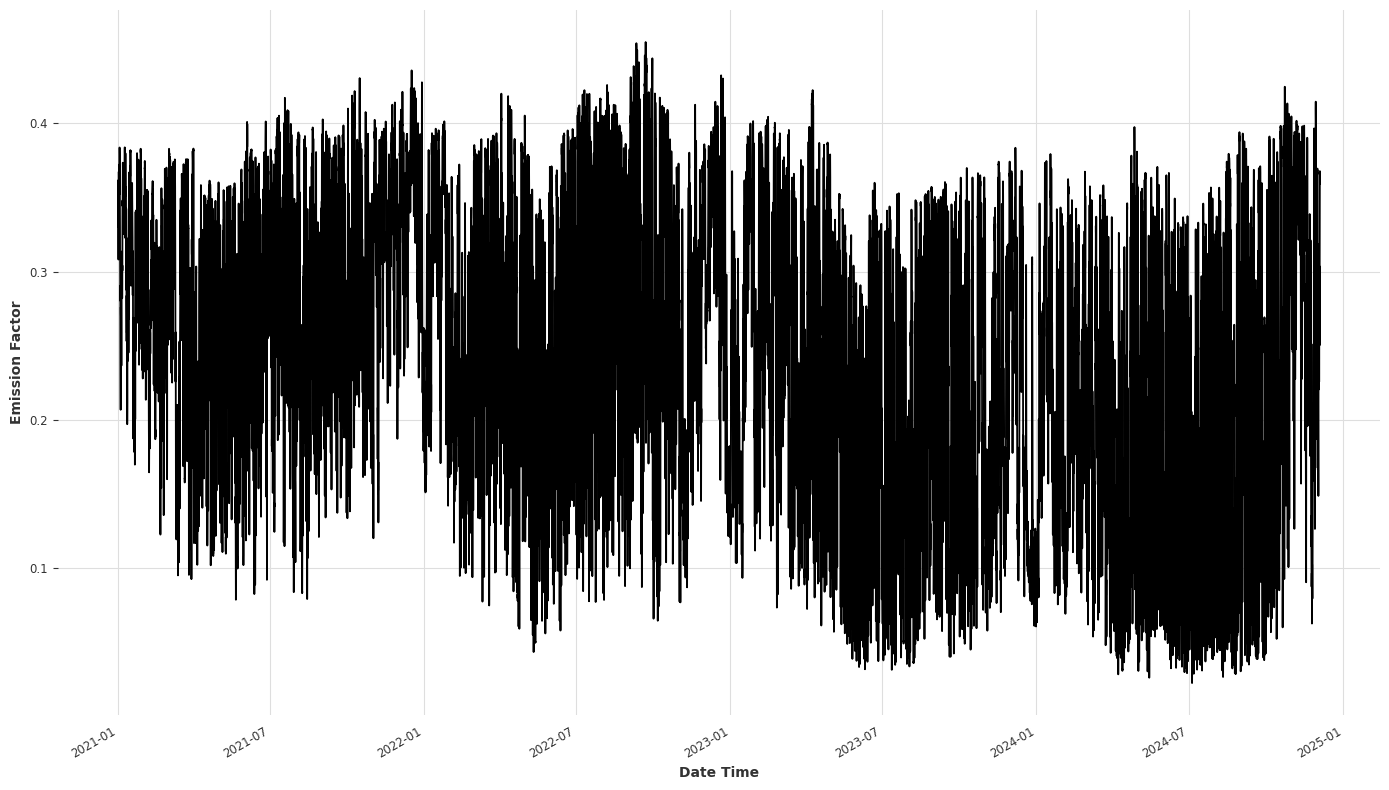

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))

# Explicitly use 'date_time' as the x-axis
ax.plot(energy_df['date_time'], energy_df['emissionfactor'])

# Set axis labels
ax.set_xlabel('Date Time')
ax.set_ylabel('Emission Factor')

# Format x-axis to display dates properly
fig.autofmt_xdate()
plt.tight_layout()

# Show plot
plt.show()

In [15]:
mstl = MSTL(energy_df['emissionfactor'], periods=[24, 24*7, 24*7*52], iterate = 3)
res = mstl.fit()


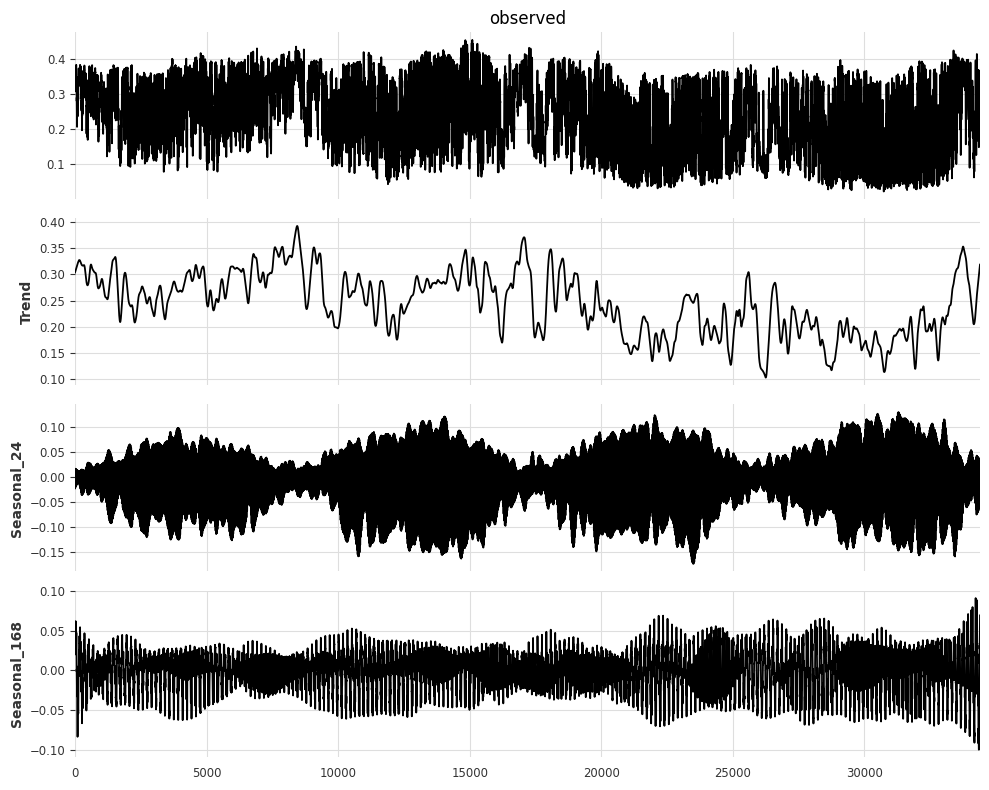

In [ ]:
# Applying multiple seasonal trend decomposition by Loess (MSTL)
plt.rcParams['figure.figsize'] = (10,8)
res.plot(resid = False)
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import STL
decomposition = STL(energy_df['emissionfactor'], period=24, robust=True).fit()

residuals = decomposition.resid
seasonal_factor = decomposition.seasonal
trend = decomposition.trend
print(trend)

ValueError: period must be a positive integer >= 2

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='resid'>)

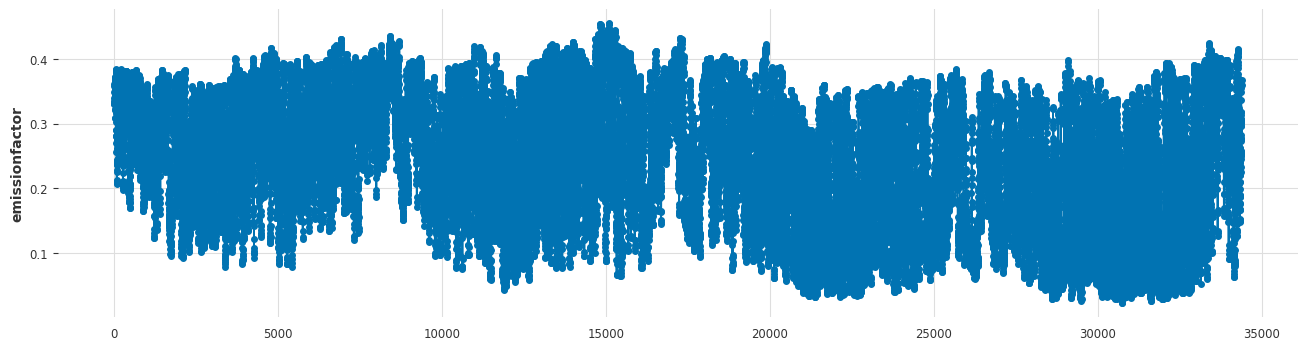

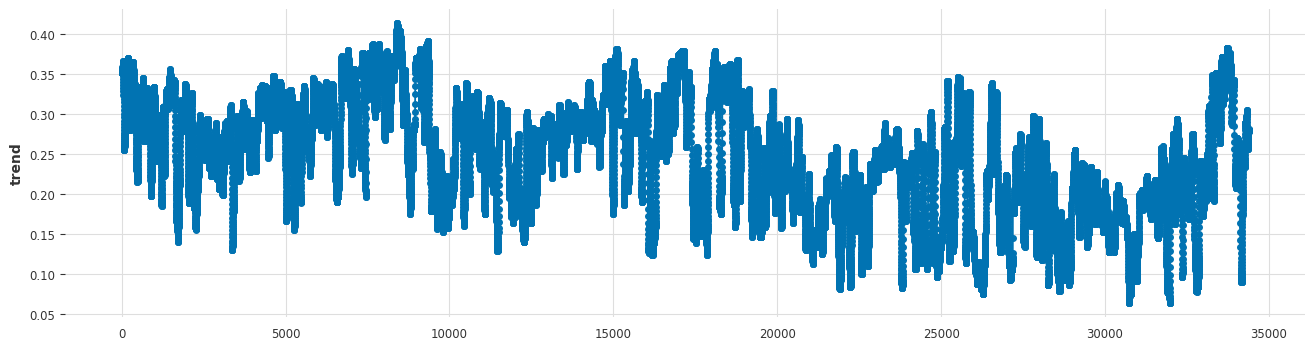

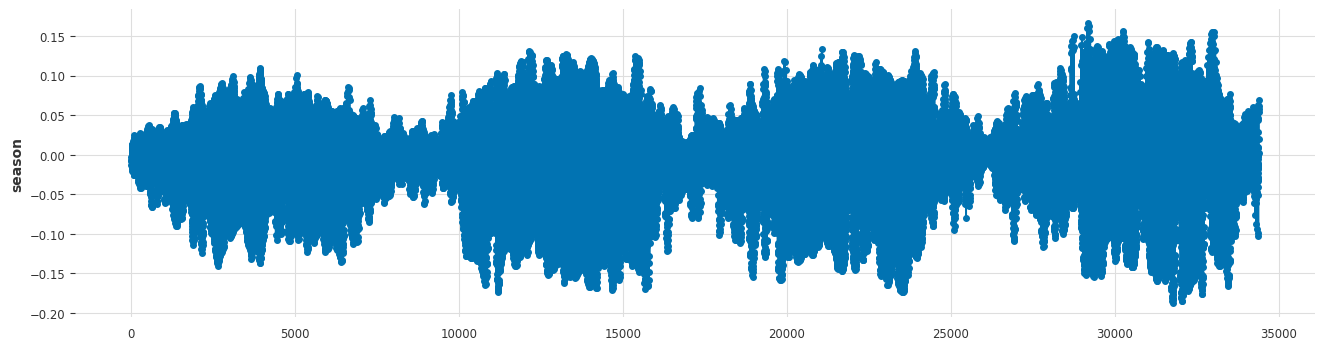

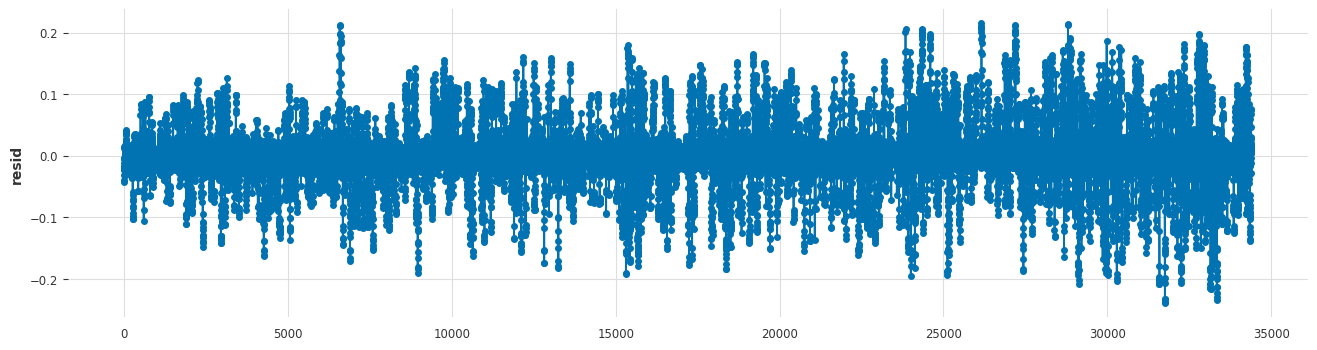

In [14]:
plot_series(energy_df['emissionfactor'])
plot_series(trend)
plot_series(seasonal_factor)
plot_series(residuals)

In [6]:
energy_df_D = energy_df.copy()

# Step 1: Ensure date_time is in datetime format
energy_df_D['date_time'] = pd.to_datetime(energy_df_D['date_time'])

# Step 2: Set date_time as the index
energy_df_D = energy_df_D.set_index('date_time')

# Step 3: Resample to daily frequency and compute the mean
energy_df_D_resampled = energy_df_D.resample('D').mean()
mstl = MSTL(energy_df_D_resampled['emissionfactor'], periods=[24*7, 24*7*52], iterate = 1)
res = mstl.fit()

c:\Projects\TeSoPs\Syntax\venv\Lib\site-packages\statsmodels\tsa\stl\mstl.py:218: UserWarning: A period(s) is larger than half the length of time series. Removing these period(s).
  warnings.warn(


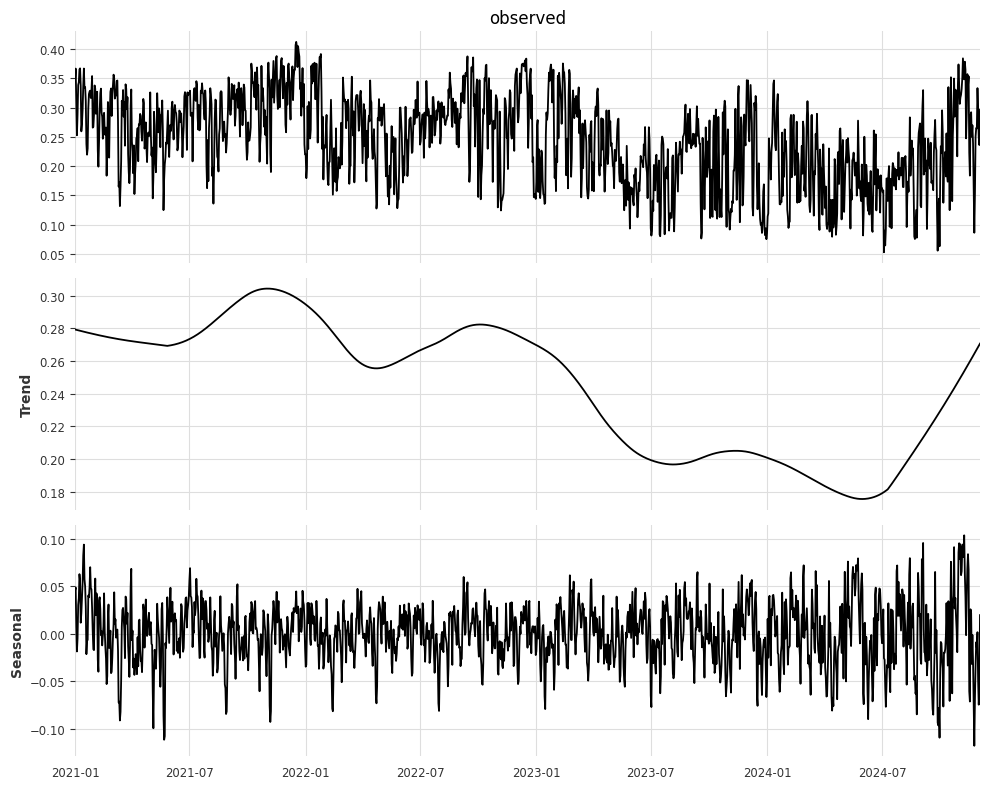

In [7]:
# Applying multiple seasonal trend decomposition by Loess (MSTL)
plt.rcParams['figure.figsize'] = (10,8)
res.plot(resid = False)
plt.show()

In [101]:
# Check whether seasonal periods in co2 emission data are significant.
series = TimeSeries.from_dataframe(energy_df, time_col='date_time')

is_daily_seasonal, daily_period = check_seasonality(series, m=24, max_lag=400, alpha=0.05)
is_weekly_seasonal, weekly_period = check_seasonality(series, m=168, max_lag=400, alpha=0.05)
is_yearly_seasonal, yearly_period = check_seasonality(series, m=8760, max_lag=10000, alpha=0.05)

print(f'Daily seasonality: {is_daily_seasonal} - period = {daily_period}')
print(f'Weekly seasonality: {is_weekly_seasonal} - period = {weekly_period}')
print(f'Yearly seasonality: {is_yearly_seasonal} - period = {yearly_period}')

Daily seasonality: True - period = 24
Weekly seasonality: True - period = 168
Yearly seasonality: True - period = 8760


In [7]:
# create a smaller datasxet for testing
#subset_df = energy_df[energy_df['date_time'] > '2022-09-01 04:00:00']

In [ ]:
# fig, ax = plt.subplots(figsize=(14, 8))

# # Explicitly use 'date_time' as the x-axis
# ax.plot(subset_df['date_time'], subset_df['emissionfactor'])

# # Set axis labels
# ax.set_xlabel('Date Time')
# ax.set_ylabel('Emission Factor')

# # Format x-axis to display dates properly
# fig.autofmt_xdate()
# plt.tight_layout()

# # Show plot
# plt.show()

## Modeling 

In [36]:
y = energy_df['emissionfactor']

# forecasting horiozon 7 x 24 hours
fh = np.arange(1, 169) 

### Autocorrelations

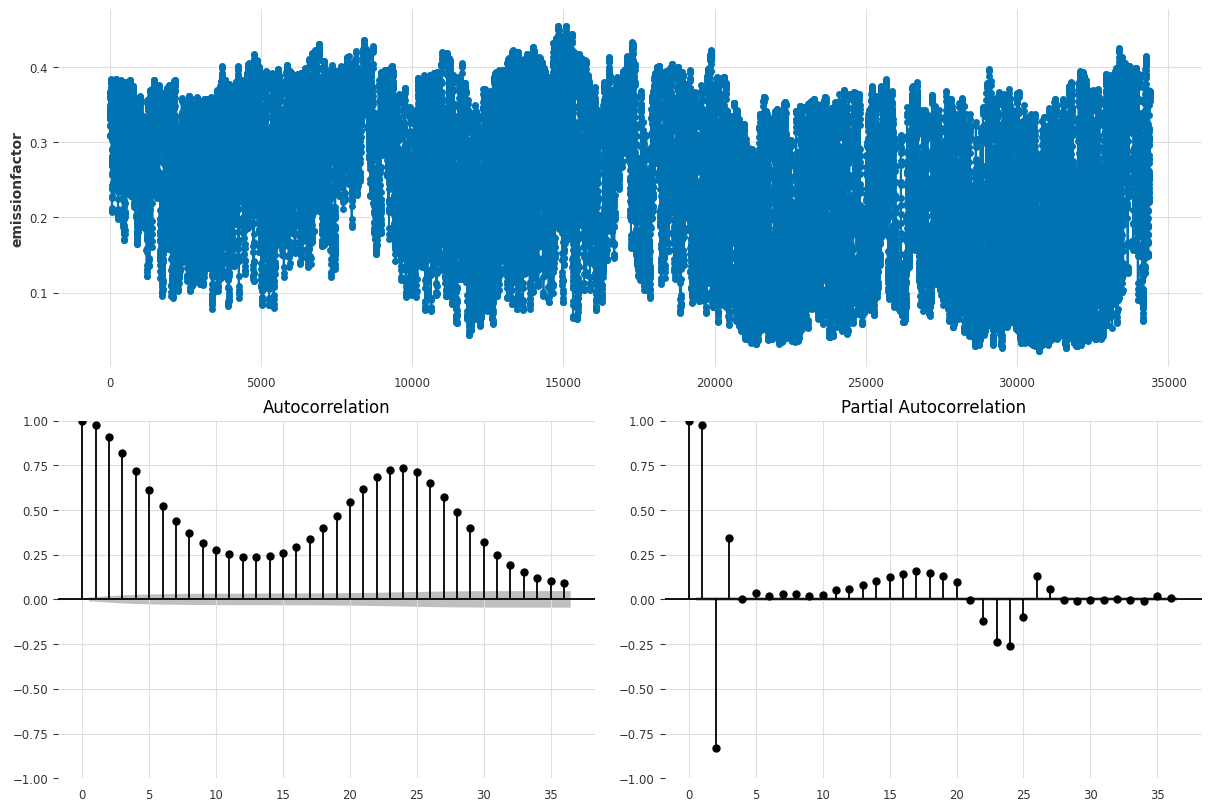

In [11]:
fig,ax = plot_correlations(y, lags = 36)
# r24 is higher than the other lags due to the daily pattern in the data. The data also have a trend because the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in value.

In [ ]:
#Selection criteria for the order of ARIMA model :

#p : Lag value where the Partial Autocorrelation (PACF) graph cuts off or drops to 0 for the 1st instance.
#d : Number of times differencing is carried out to make the time series stationary.
# q : Lag value where the Autocorrelation (ACF) graph crosses the upper confidence interval for the 1st instance.
p = 2, d = 0, q = 2

In [12]:
# Augmented Dickey-Fuller unit root test

#The null hypothesis (H₀) of the ADF test is that the series has a unit root (i.e., it is non-stationary).
#The alternative hypothesis (H₁) is that the series is stationary.

#To reject the null hypothesis, you have two criteria:

#p-value: If p-value < 0.05, reject H₀ (time series is stationary).
#ADF Statistic: If ADF Statistic < Critical Value, reject H₀ (time series is stationary).

adfuller(y)


#Test Statistic = -13.34
#Critical Value at 1% = -3.4307
#Since -13.34 < -3.4307, you reject the null hypothesis at the 1% significance level, meaning the series is stationary.
# The further the test statistic is from 0 (in the negative direction), the stronger the evidence for stationarity.

#The second value, 2.87e-17, is the p-value for the test.

#The p-value tells you the probability of observing the given test statistic under the null hypothesis.
#If the p-value is less than 0.05, you reject the null hypothesis, meaning the series is stationary.
#Here, the p-value is extremely small (2.87e-17), meaning the test provides very strong evidence to reject the null hypothesis of non-stationarity.
#This means the series is stationary at the 1%, 5%, and 10% confidence levels. This means that no differencing is required for models like ARIMA.

(-13.338445366261995,
 5.986642496276096e-25,
 51,
 34340,
 {'1%': -3.4305404423088253,
  '5%': -2.8616241707434598,
  '10%': -2.5668148014501937},
 -220170.16061313165)

In [13]:
y_train, y_test = temporal_train_test_split(y, test_size=168)
print(len(y_train), len(y_test))

34224 168


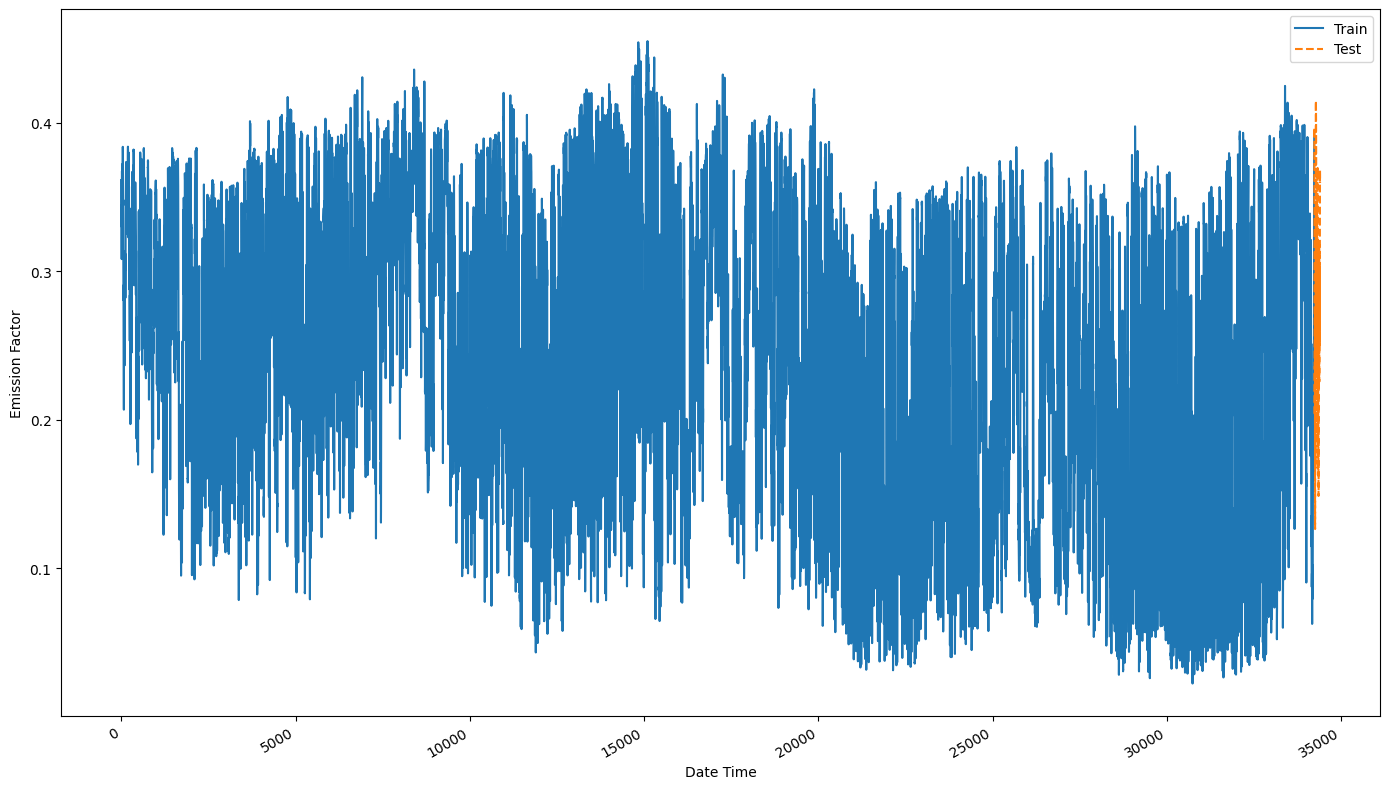

In [107]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_train, ls='-', label='Train')
ax.plot(y_test, ls='--', label='Test')
ax.set_xlabel('Date Time')
ax.set_ylabel('Emission Factor')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

### Baseline 

In [14]:
y_pred_baseline = y_train[-168:].values

### Reduce the training set to 10 weeks

In [37]:
y_train = y_train[-1680:]

print(y_train.shape, y_test.shape)
print(y_train.head())
print(len(y_train))

(1680,) (168,)
32544    0.236079
32545    0.244157
32546    0.238615
32547    0.242954
32548    0.272021
Name: emissionfactor, dtype: float64
1680


In [16]:
# Automatically search for the best ARIMA/SARIMAX configuration
auto_model = auto_arima(
    y_train, 
    seasonal=True, 
    m=24,  # Use daily seasonality as the baseline
    stepwise=True, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-10011.282, Time=5.07 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-7513.459, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-9702.434, Time=5.62 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-9237.542, Time=7.87 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-7515.438, Time=0.12 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-9743.108, Time=21.11 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-9867.609, Time=21.45 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=-10057.462, Time=83.75 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=-9990.554, Time=50.29 sec
 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=-9972.889, Time=32.66 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=-10063.054, Time=141.60 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=-9837.554, Time=86.99 sec
 ARIMA(1,1,2)(1,0,2)[24] intercept   : AIC=-10029.910, Time=46.08 sec
 ARIMA(2,1,1)(1,0,2)[24] intercept   : AIC=-10032.772, Time=

In [38]:
print(auto_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1680
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood                5066.900
Date:                            Thu, 19 Dec 2024   AIC                         -10123.800
Time:                                    15:05:38   BIC                         -10096.670
Sample:                                         0   HQIC                        -10113.750
                                           - 1680                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6262      0.022     28.878      0.000       0.584       0.669
ma.L1          0.2464      0.026   

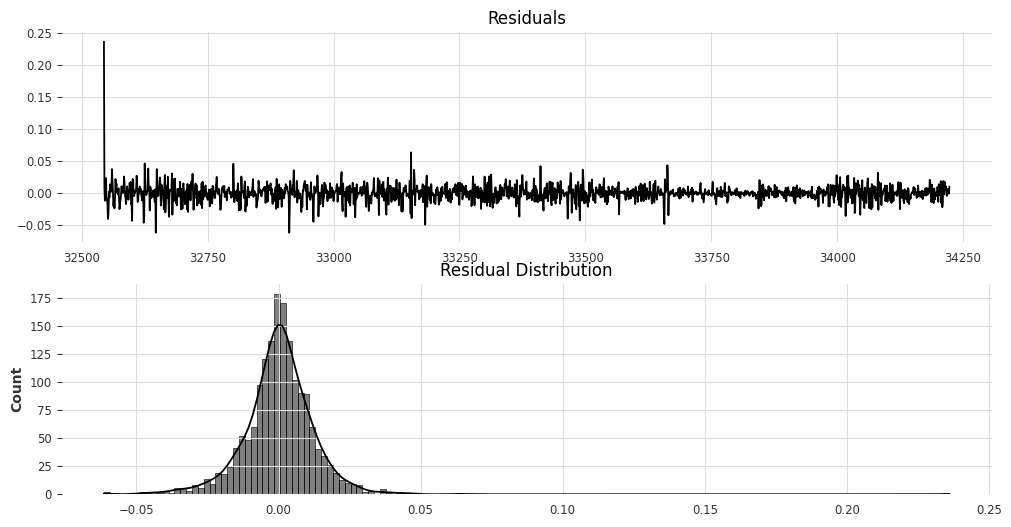

In [39]:
# Extract residuals from the model
residuals = auto_model.resid()

# Plot residuals
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()


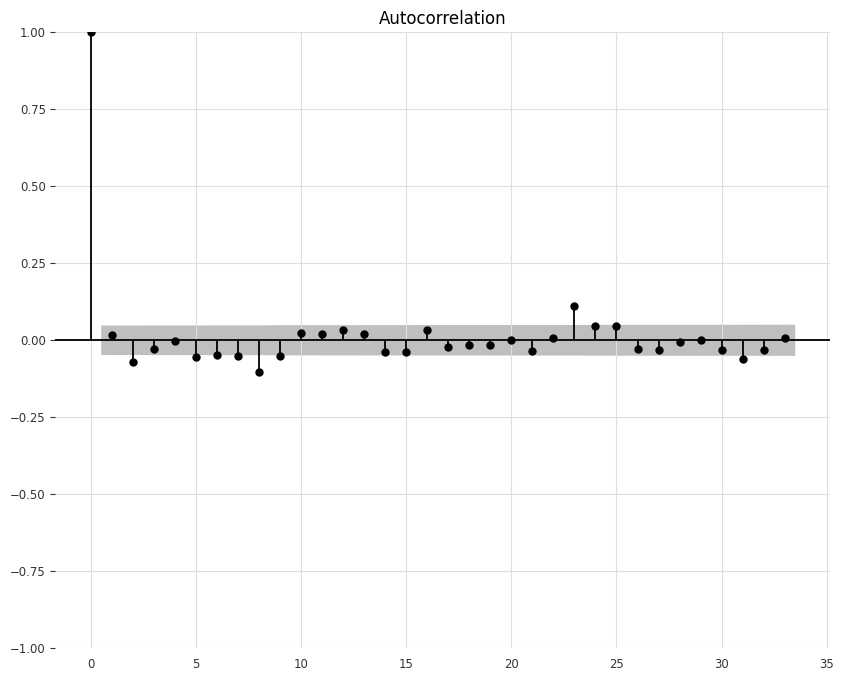

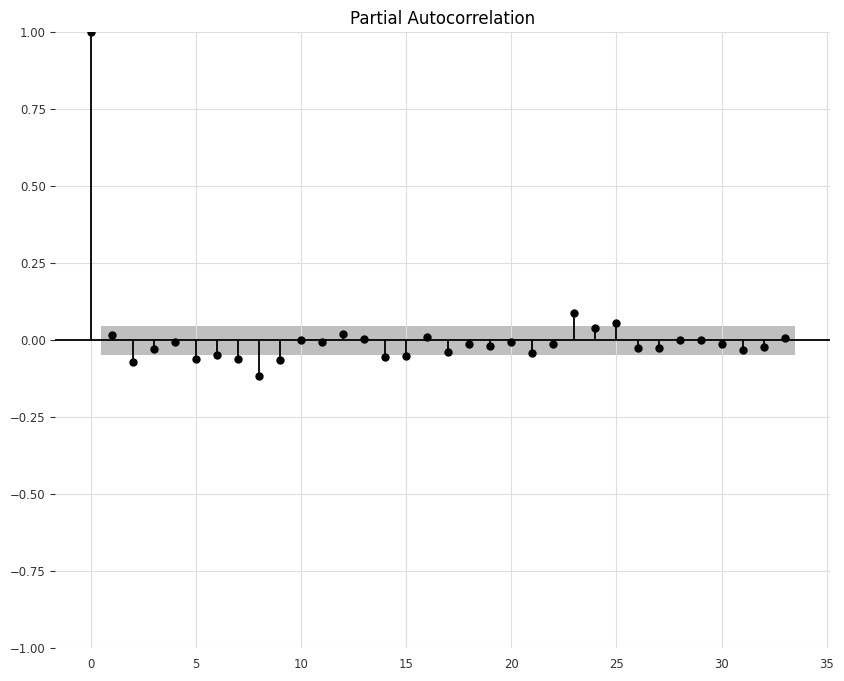

In [18]:
# Plot ACF and PACF of residuals
plot_acf(residuals)
plt.show()

plot_pacf(residuals)
plt.show()

In [29]:
# running the best model (ARIMA(1,1,1)(1,0,1)[24]) with sktime
forecaster_arima = ARIMA(order=(1, 1, 1), seasonal_order = (1, 0, 1, 24), suppress_warnings=True)
forecaster_arima.fit(y_train)
forecaster_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1680
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood                5066.245
Date:                            Thu, 19 Dec 2024   AIC                         -10120.490
Time:                                    15:00:09   BIC                         -10087.934
Sample:                                         0   HQIC                        -10108.430
                                           - 1680                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.871e-05   5.71e-05     -0.328      0.743      -0.000    9.31e-05
ar.L1          0.6151      0.022     28.169      0.000       0.572       0.658
ma.L1          0.2487      0.026      9.505      0.000       0.197       0.300
ar.S.L24       0.9598      0.006    147.874      0.000       0.947       0.973
ma.S.L24      -0.7857      0.018    -43.611      0.000      -0.821      -0.750
sigma2         0.0001   3.51e-06     39.461      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):               584.96
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
forecaster_arima.save(path="models/sarimax_model")

<zipfile.ZipFile filename='models\\sarimax_model.zip' mode='r'>

In [42]:
y_pred_SARIMAX = forecaster_arima.predict(fh)

c:\Projects\TeSoPs\Syntax\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Projects\TeSoPs\Syntax\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### BATS 

In [45]:
forecaster_bats = BATS(use_box_cox=False,
                   use_trend=True,
                   use_damped_trend=True,
                   sp=[24, 168],
                   n_jobs=-1)

In [ ]:
#bats_model = forecaster_bats.fit(y_train)
#bats_model.save(path="models/bats_model")

### Loading a saved fitted BATS model

In [46]:
bats_model = forecaster_bats.load_from_path("models/bats_model.zip")

In [47]:
y_pred_BATS = bats_model.predict(fh)

### TBATS 

In [29]:
# we specify the seasonal periods, which are 24 (for the daily seasonality) and 168 (for the weekly seasonality) [and 8760 (for the yearly seasonality)]
forecaster = TBATS(use_box_cox=False,
                 use_trend=True,
                 use_damped_trend=True,
                 sp=[24, 168],
                 use_arma_errors = False,
                 n_jobs=-1)   

In [32]:
#tbats_model = forecaster.fit(y_train)
#tbats_model.save(path="models/tbats_model")

<zipfile.ZipFile filename='models\\tbats_model.zip' mode='r'>

### Loading a saved fitted TBATS model

In [17]:
tbats_model = forecaster.load_from_path("models/tbats_model.zip")

In [33]:
y_pred_TBATS = forecaster.predict(fh)

In [ ]:

forecaster_ar = ARIMA(order=(2, 1, 2), seasonal_order = (0, 1, 1, 12), suppress_warnings=True)
forecaster.fit(y_train)
forecaster.summary()

### Prophet

In [86]:
forecaster_prop = Prophet(
    seasonality_mode="additive",
    #n_changepoints=int(len(y_train) / 24),
    #add_country_holidays={"country_name": "Netherlands"},
    #yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
)

In [87]:
forecaster_prop.fit(y_train)

12:08:39 - cmdstanpy - INFO - Chain [1] start processing
12:08:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet(daily_seasonality=True, weekly_seasonality=True)

In [88]:
future = forecaster_prop.make_future_dataframe(periods=24, freq = 'H')
#forecast = m.predict(future)

AttributeError: 'Prophet' object has no attribute 'make_future_dataframe'

0.5172235274213721

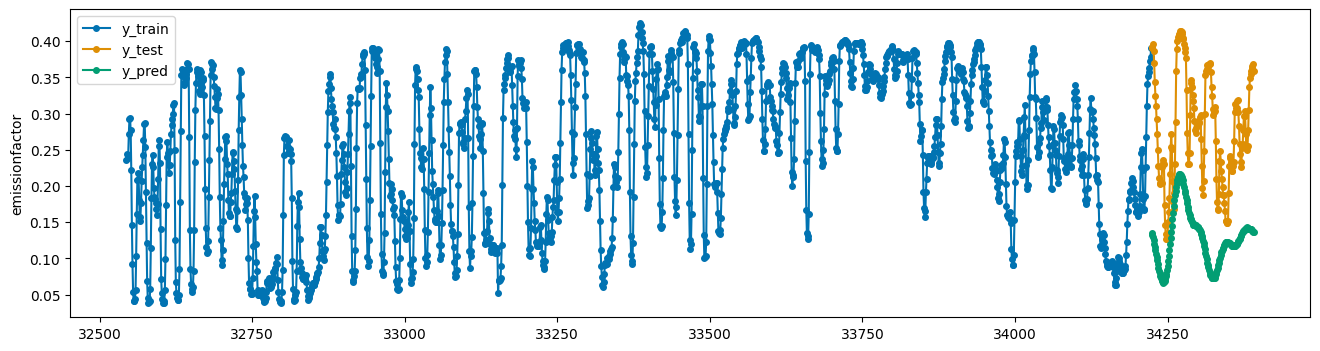

In [ ]:

y_pred_prophet = forecaster_prop.predict(fh)
#y_pred_prophet = forecaster_prop.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred_prophet.index = y_test.index

plot_series(y_train, y_test, y_pred_prophet, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred_prophet, symmetric=False)

In [24]:
loss = mean_squared_error
tbats_loss = loss(y_test, y_pred_TBATS)
tbats_loss

0.01118118450682741

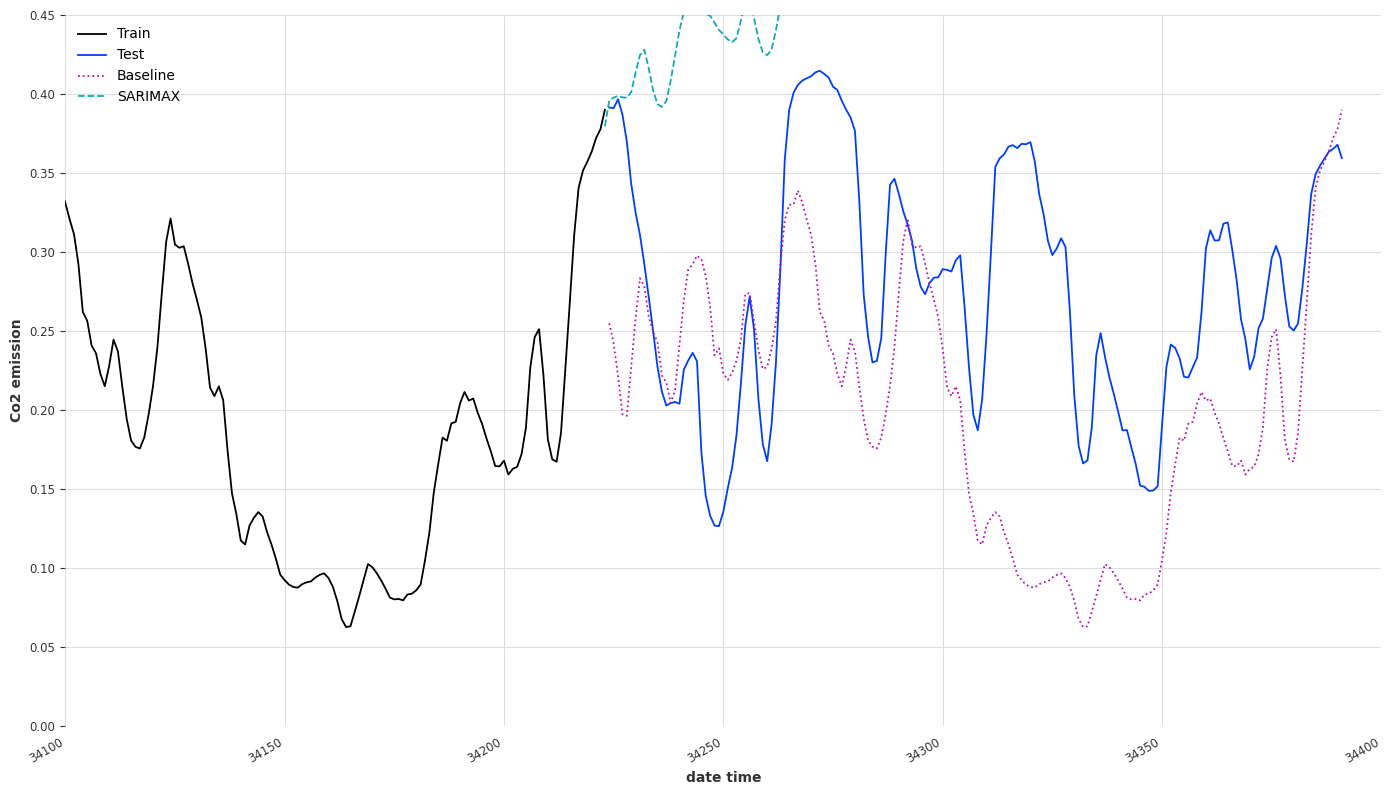

In [43]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_train, ls='-', label='Train')
ax.plot(y_test, ls='-', label='Test')
ax.plot(y_test.index, y_pred_baseline, ls=':', label='Baseline')
#ax.plot(y_pred_BATS, ls='--', label='BATS')
ax.plot(y_pred_SARIMAX, ls='--', label='SARIMAX') 
#ax.plot(y_pred_TBATS, ls='-.', label='TBATS')
#ax.plot(y_pred_prophet, ls='-.', label='Prophet')
ax.set_xlabel('date time')
ax.set_ylabel('Co2 emission')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

plt.xlim(34100, 34400)
plt.ylim(0, 0.45)

plt.show()

<Axes: >

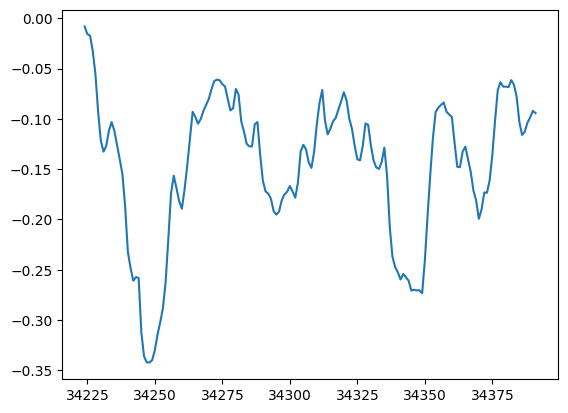

In [75]:
res = forecaster.predict_residuals(y_test)
res.plot()


In [20]:
print(res)

34124    0.014245
34125   -0.012397
34126    0.014107
34127    0.002149
34128   -0.001693
           ...   
34219    0.004041
34220    0.004300
34221    0.004415
34222   -0.000971
34223    0.008184
Name: emissionfactor, Length: 100, dtype: float64


In [44]:
fitted_values = forecaster.predict(fh=[i for i in range(1, len(y) + 1)])
print(fitted_values)

34224    0.397326
34225    0.397685
34226    0.397297
34227    0.399415
34228    0.406733
           ...   
54014    0.163291
54015    0.184812
54016    0.203657
54017    0.215659
54018    0.220264
Name: emissionfactor, Length: 19795, dtype: float64


In [42]:
# Fit forecaster to training data
tbats_fitted = forecaster.fit(y_train)

In [43]:
fitted_params = tbats_fitted.get_fitted_params(deep=True)
print(fitted_params)


{'a': None, 'i': None, 'c': None}


In [33]:
fitted_values = tbats_fitted.get_fitted_params()
print(fitted_values)

{'a': None, 'i': None, 'c': None}


In [41]:
# Creating a Utility Metrics Function
#https://www.linkedin.com/pulse/tbats-python-tutorial-examples-ikigailabs
def print_metrics(y_true, y_pred, model_name):
    mae_ = mean_absolute_error(y_true, y_pred)
    rmse_ = mean_squared_error(y_true, y_pred, square_root = True)
    mape_ = mean_absolute_percentage_error(y_true, y_pred)
    smape_ = mean_absolute_percentage_error(y_true, y_pred, symmetric = True)
    
    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_ }
    
    df = pd.DataFrame(dict_, index = [model_name])
    return(df.round(decimals = 2))

In [60]:
print(f'Length of y_true: {len(y_test)}')
print(f'Length of y_pred: {len(y_pred_TBATS)}')

print_metrics(y_test, y_pred_TBATS, 'TBATS Forecaster')

Length of y_true: 168
Length of y_pred: 168


,MAE,RMSE,MAPE,SMAPE
TBATS Forecaster,0.08,0.11,0.38,0.27


In [42]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,2)

In [43]:
mape_baseline = mape(y_test, y_pred_baseline)
mape_BATS = mape(y_test, y_pred_BATS)
mape_TBATS = mape(y_test, y_pred_TBATS)

print(f'MAPE from baseline: {mape_baseline}')
print(f'MAPE from BATS: {mape_BATS}')
print(f'MAPE from TBATS: {mape_TBATS}')

MAPE from baseline: 34.6
MAPE from BATS: 27.56
MAPE from TBATS: 42.76


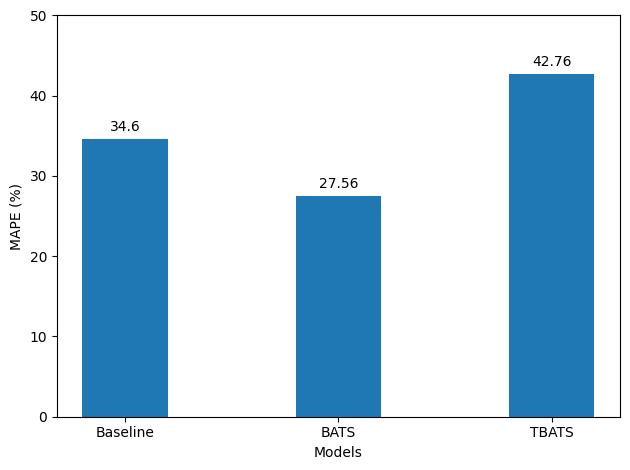

In [44]:
fig, ax = plt.subplots()

x = ['Baseline', 'BATS','TBATS']
y = [mape_baseline, mape_BATS, mape_TBATS]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 50)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()